Las mediciones que queremos hacer aquí son las siguientes:
- Velocidad promedio respecto al número de autos:
    - Promedio sobre los días - Termalización
    - Promedio usando el mismo número de autos pero diferente distribución de orígenes destinos
   
- Ver con qué número de autos se alcanza la saturación y meter diferentes tipos de diagonales.
- ¿Los autos regresan a caminos previos? ¿Se forman ciclos? ¿Hay estados estacionarios?

La velocidad de cada auto en todo su trayecto:
- Distancia en su recorrido total entre t_llegada-t_salida.
- Distancia absoluta entre t_llegada-t_salida.
- El promedio de su diccionario propio de velocidades.

Gráficas de cómo avanzan estas variables a través de los días para densidades de auto fijas, y luego para el día n cómo cambian para diferentes densidades.

Distancia promedio (sobre la red) que recorren los automóviles.

Hasta dónde puedo hacer crecer la red.

Verificar si los autos van cambiando de ruta conforme pasan los días.

Es más probable que haya efectos en casos donde hay diagonales

In [1]:
using DataFrames, GraphPlot, Impute, Plots, Colors, Statistics, Random, Distributions
dir = "../Mariana-Paquete/Mariana-Basefunc/"

include(dir*"funciones_de_red.jl")
include(dir*"objetos.jl")
include(dir*"dinamica_conductores.jl")
include(dir*"animaciones.jl")

plot_digraph (generic function with 1 method)

# Parametros

In [2]:
tamano_red = 5;
doble_sentido = true;
center_h_dist = 0.5;
sd_h_dist = 0;
h_distribution = Normal(center_h_dist, sd_h_dist);
n_cars = 2000;
ti = 0.0;
tf = 150;
max_n_dias = 200;


## Generación de la red 

In [3]:
red_cuadrada = create_square_network(tamano_red, both_ways=doble_sentido);
SqNet= red_cuadrada.digraph;
m = nv(SqNet);
posarr = red_cuadrada.position_array;
city_mt = red_cuadrada.city_matrix;

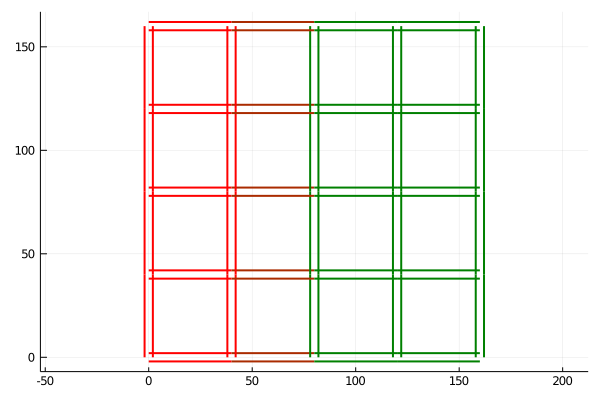

In [4]:
plot_digraph(SqNet, posarr,attribute_matrix=city_mt[:,:,4], separated_edges=true)

# Generación de los autos

In [5]:
autos = generate_autos(m,red_cuadrada,n_cars,ti,tf,h_distribution);

# Simulacion

In [6]:
n_dias = max_n_dias;
day = 0;
min_vels = []
avg_vels = []
cars_changing = []

n = 200
while n > 0 
    print("día $(day) \n")
    times, vels = simulacion!(0., red_cuadrada, autos);
    min_vel, avg_vel = get_avg_vel(autos)
    push!(min_vels,min_vel)
    push!(avg_vels,avg_vel)
        
    print(min_vel," ", avg_vel,"\n")
    old_n = n
    n = restart(autos, red_cuadrada)
    push!(cars_changing, n)
        
    if old_n == n
        break
    end
        
    day += 1
end

día 0 
7.999870263580142 11.38050549707312
836 cars changed A* path 
día 1 
7.999912011101033 11.402128617001313
435 cars changed A* path 
día 2 
7.999912011101033 11.38876451134836
202 cars changed A* path 
día 3 
7.999915867521518 11.388573134080422
87 cars changed A* path 
día 4 
7.999915867521518 11.388464401985155
35 cars changed A* path 
día 5 
7.999915867521518 11.388225756035402
16 cars changed A* path 
día 6 
7.999915867521518 11.38816742167092
4 cars changed A* path 
día 7 
7.999915867521518 11.388167422935137
2 cars changed A* path 
día 8 
7.999915867521518 11.38816742369648
0 cars changed A* path 


In [7]:
df = DataFrame(min_vel = min_vels, 
               avg_vel = avg_vels,
               cars_changed = cars_changing
               )

,min_vel,avg_vel,cars_changed
,Any,Any,Any
1,7.99987,11.3805,836
2,7.99991,11.4021,435
3,7.99991,11.3888,202
4,7.99992,11.3886,87
5,7.99992,11.3885,35
6,7.99992,11.3882,16
7,7.99992,11.3882,4
8,7.99992,11.3882,2
9,7.99992,11.3882,0


In [8]:
using CSV
CSV.write("test.csv", df)

"test.csv"

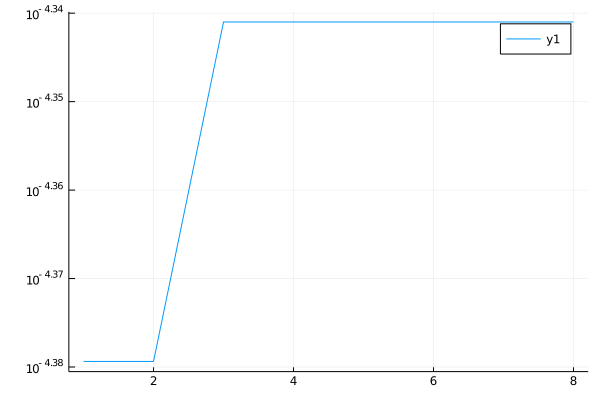

In [18]:
plot((min_vels.-min_vels[1])[2:end], yscale = :log10)

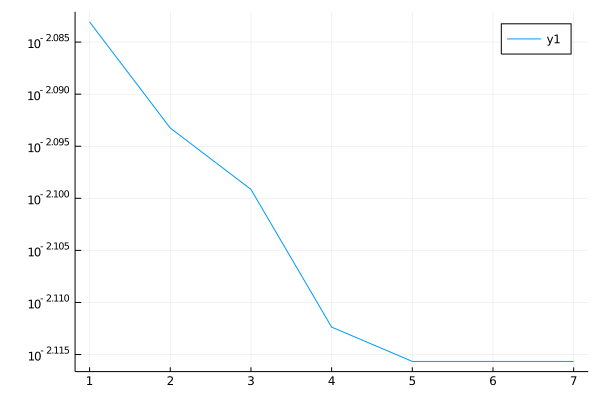

In [21]:
plot((avg_vels.-avg_vels[1])[3:end], yscale = :log10)

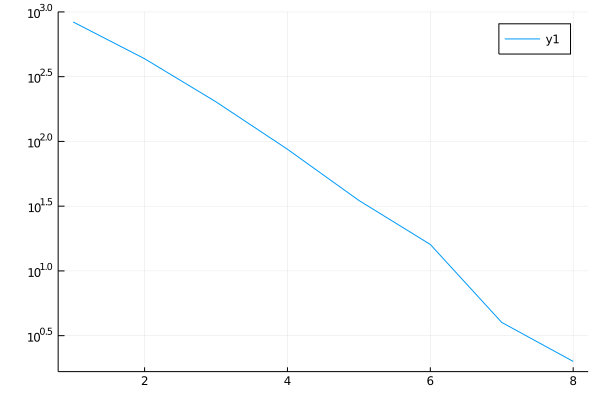

In [16]:
plot(cars_changing[1:end-1], yscale= :log10)

Ir imprimendo porcentaje de autos que ha salido y llegado cada n pasos de tiempo

Siguientes pasos:
- Calles de 25-40 m
- Más calles
- Autos de 4m
- Mediciones

Paralelizar sobre las densidades
Revisar el problema de los NaN y que se está incrementando la velocidad en vez de reducirse, corregir velocidades/tiempo. La posición inicial y el destino deben estar separados al menos cierta distancia

todos salen de un lado y todos llegan al lado opuesto

Tratar de hacer una red más grande